# Laplace equation 2D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

Let $\Omega$ be the unit square

> PDE: $\Delta u(x,y) = 0$ for $x\in\Omega$

> BC: $u(x,0) = \sin(\pi x)$, $u(x,1) = 0$, $u(0,y) = 0$, $u(1,y) = 0$


Description: Equilibrium temperature distribution for a rectangular plate. 

We know the analytical solution is given by 

$$
u(x, y)=\sum_{n=1}^{\infty} a_n \sin (n \pi x) \sinh (n \pi(1-y))
$$

## Libraries

In [2]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [3]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *
from integrate import trap
from sklearn.metrics import mean_squared_error

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [4]:
def Kphiphi_assembly(Xomega, Xboundary , k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian2D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,M))

  # Block 1,1 
  val = K_ddddot2D(kernel, Xomega, Xomega, k_param, 0, 0, 1, 1)
  Theta = Theta.at[:Momega, :Momega].set(val)

  # Block 1,2
  val = K_ddot2D(kernel, Xomega, Xboundary, k_param, 0, 0) 
  Theta = Theta.at[:Momega, Momega:].set(val)
  Theta = Theta.at[Momega:, :Momega].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K_2D(kernel, Xboundary , Xboundary, k_param)
  Theta = Theta.at[Momega:, Momega:].set(val)

  return Theta

In [5]:
def Kphi_assembly(Xtest, Xomega, Xboundary, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian2D

  # Size of the square matrix
  Momega = len(Xomega)
  Mboundary = len(Xboundary)
  Mtest = len(Xtest)
  M = Momega + Mboundary

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M,Mtest))

  # Block 1
  val = K_ddot2D(kernel, Xomega, Xtest, k_param, 0, 0)
  Theta = Theta.at[:Momega, :].set(val)

  # Block 2
  val = K_2D(kernel, Xboundary , Xtest, k_param)
  Theta = Theta.at[Momega:, :].set(val)


  return Theta

In [6]:
def generate_pts_interior(num_points_per_axis):
    # Generate a grid of evenly spaced points in the range [0, 1]
    x = np.linspace(0, 1, num_points_per_axis)
    y = np.linspace(0, 1, num_points_per_axis)

    # Create a meshgrid from the x and y coordinates
    xx, yy = np.meshgrid(x, y)

    # Reshape the meshgrid to obtain a list of points
    points = np.column_stack((xx.ravel(), yy.ravel()))

    return points

def generate_pts_boundary(num_points):
    # Generate random coordinates on the four sides of the unit square
    x = np.concatenate((
        np.random.random(num_points),               # points on the bottom side
        np.ones(num_points),                        # points on the right side
        np.random.random(num_points),               # points on the top side
        np.zeros(num_points)                        # points on the left side
    ))

    y = np.concatenate((
        np.zeros(num_points),                       # points on the bottom side
        np.random.random(num_points),               # points on the right side
        np.ones(num_points),                        # points on the top side
        np.random.random(num_points)                # points on the left side
    ))

    points = np.column_stack((x, y))
    return points

## How far can we go ?

Generate the points

In [7]:
# sqrt(M_Omega)
Momega = int(np.sqrt(400))
# M - M_Omega 
M_boundary = 20
# X_{\partial\Omega}
Xboundary = generate_pts_boundary(M_boundary)
# X_\Omega
Xomega = generate_pts_interior(Momega)
# X_full
Xfull = np.vstack((Xomega, Xboundary))
# Boundary condition value
f_bottom = f_bc(Xboundary[:M_boundary,0])
# kparam
k_param = 0.5

Build `Kphiphi`

In [8]:
Kphiphi = Kphiphi_assembly(Xomega, Xboundary, k = 'Gaussian', k_param = k_param)

Build `y_prev`

In [9]:
y_prev = jnp.concatenate((np.zeros((len(Xomega)),),f_bottom,np.zeros((len(Xboundary[M_boundary:,])),)))

Compute $K(\varphi,\varphi)^{-1}y_{\text{prev}}$

In [10]:
R = jnp.diag(jnp.diag(Kphiphi))
sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

Get `K(Xtest,Xfull)`

In [11]:
# sqrt(M_Omega)
M_int = int(np.sqrt(4000))
# M - M_Omega 
M_bry = 200
# X_{\partial\Omega}
X_test_bry = generate_pts_boundary(M_bry)
# X_\Omega
X_test_int = generate_pts_interior(M_int)
# X_test
X_test = np.vstack((X_test_int, X_test_bry))

In [12]:
Kphi = Kphi_assembly(X_test, Xomega, Xboundary, k = 'Gaussian', k_param = k_param)

In [13]:
u_next = np.dot(Kphi.T,sol)

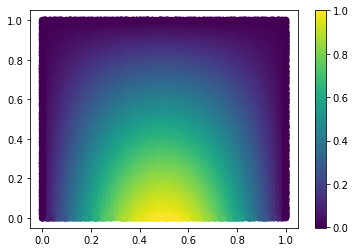

In [14]:
# Initial condition
#plt.plot(Xfull,transport_u0(Xfull),'.-',label='init')
# True next
#plt.plot(Xfull,transport_sol(Xfull,h,c),'.-',label='true_next')
# Predicted next
sc = plt.scatter(X_test[:,0], X_test[:,1], c = u_next,label='pred')
plt.colorbar(sc)
# Plot settings
#nmse = mean_squared_error(u_next,transport_sol(Xfull,h,c))/mean_squared_error(0*transport_sol(Xfull,h,c),transport_sol(Xfull,h,c))
#plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
#plt.legend()
plt.show()

In [15]:
u_true = lap_sol(X_test[:,0], X_test[:,1], 30)

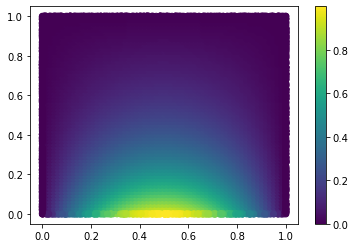

In [16]:
# Initial condition
#plt.plot(Xfull,transport_u0(Xfull),'.-',label='init')
# True next
#plt.plot(Xfull,transport_sol(Xfull,h,c),'.-',label='true_next')
# Predicted next
sc = plt.scatter(X_test[:,0], X_test[:,1], c = u_true,label='pred')
plt.colorbar(sc)
# Plot settings
#nmse = mean_squared_error(u_next,transport_sol(Xfull,h,c))/mean_squared_error(0*transport_sol(Xfull,h,c),transport_sol(Xfull,h,c))
#plt.title('t = {} | Normalized MSE:{}'.format(h, round(nmse,7)))
#plt.legend()
plt.show()

## Convergence

In [17]:
L2_norms = []
for n in range(2,6):
    # sqrt(M_Omega)
    Momega = int(np.sqrt(2**n))
    # M - M_Omega 
    M_boundary = 2**n
    # X_{\partial\Omega}
    Xboundary = generate_pts_boundary(M_boundary)
    # X_\Omega
    Xomega = generate_pts_interior(Momega)
    # X_full
    Xfull = np.vstack((Xomega, Xboundary))
    # Boundary condition value
    f_bottom = f_bc(Xboundary[:M_boundary,0])
    # kparam
    k_param = 0.5
    # Delta for numerical integration
    delta = Xfull[1,0]-Xfull[0,0]

    Kphiphi = Kphiphi_assembly(Xomega, Xboundary, k = 'Gaussian', k_param = k_param)
    y_prev = jnp.concatenate((np.zeros((len(Xomega)),),f_bottom,np.zeros((len(Xboundary[M_boundary:,])),)))

    R = jnp.diag(jnp.diag(Kphiphi))
    sol = jnp.linalg.solve(Kphiphi + 1e-6*R,y_prev)

    Kphi = Kphi_assembly(Xfull, Xomega, Xboundary, k = 'Gaussian', k_param = k_param)
    u_next = np.dot(Kphi.T,sol)

    # True solution
    u_true = lap_sol(Xfull[:,0], Xfull[:,1], 30)

    # # True next
    # plt.plot(Xfull,transport_sol(Xfull,t,c),'.-',label='true_next')
    # # Predicted next
    # plt.plot(Xfull,u_next,'.-',label='pred_next')
    # plt.legend()
    # plt.show()
    
    f = np.abs(u_next - u_true)**2
    # L2 norms
    L2_norms.append(trap(f,delta))
    print(trap(f,delta))

0.0003137971377200792
1.1392745847102306e-05
0.16011684290955036
0.1918055533890357


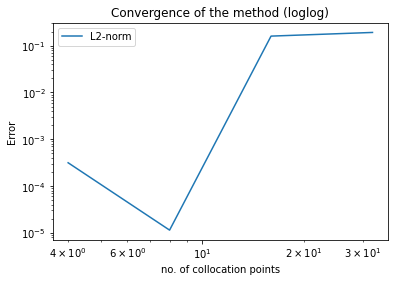

In [18]:
xrange = 2**np.arange(2,6)
#plt.loglog(xrange,sup_norms, label = 'sup-norm')
plt.loglog(xrange,L2_norms,label = 'L2-norm')
#plt.loglog(xrange,mses,label = 'mse')
plt.xlabel('no. of collocation points')
plt.ylabel('Error')
plt.legend()
plt.title('Convergence of the method (loglog)')
plt.show()